# Kelvin Wave Precipitation Reconstruction

## import package

In [32]:
import h5py
import numpy as np
import random 
import joblib as jl
import netCDF4 as nc
import matplotlib.pyplot as plt

## Functions

### FFT

In [33]:
def FFT(data):
    data_fft = np.fft.fftshift(np.fft.fft2(data))[:, ::-1]
    
    return data_fft

### Kelvin dispersion

In [34]:
def Kelvin_dispersion(ed, wn):
    return wn * (86400/(2*np.pi*6.371e6)) * np.sqrt(9.81*ed)

### Bandpass Filter

In [35]:
def Kelvin_pass(fft_data):
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(-39000, 39000, 78000)
    
    wnm, frm = np.meshgrid(wn, fr)
    
    condition = (
        (wnm >= 1) & (wnm <= 6) &
        (frm >= 1/20) & (frm <= 1/2.5) &
        (frm <= Kelvin_dispersion(90, wnm)) &
        (frm >= Kelvin_dispersion(8, wnm))
    )
    
    data_filtered = np.where(condition, fft_data*2, 0)
    
    return data_filtered

## Load data

In [36]:
# case name
PR = '0'

# file name
fname = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_600hPa_sum.dat"

# read data
with h5py.File(fname, 'r') as f:
    
    prec = f['prec'][:]*86400
    
prec = prec - prec.mean(axis=0)

## Chang's Algorithm

### Compute fft

In [37]:
prec_anamoly_fft   = np.fft.fft(prec, axis=2)
print(prec_anamoly_fft.shape)

(78000, 64, 128)


### Extract specific wave number

(78000, 64, 128)


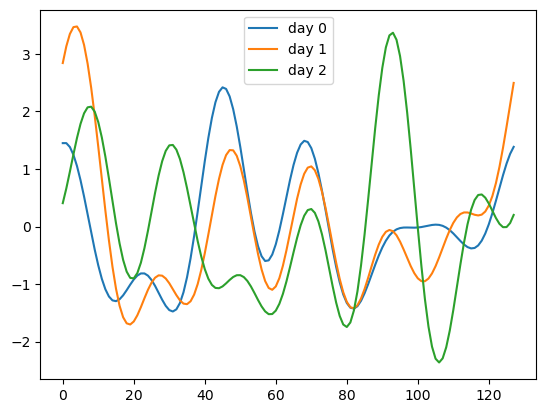

In [46]:
def extract_wave_numbers_1_to_6(data_fft):
    wn_fft = np.zeros(data_fft.shape, dtype=np.complex128)

    # Keep wave numbers 1 to 6 (positive frequencies)
    #wn_fft[:, :, 1:7] = data_fft[:, :, 1:7]

    # Keep wave numbers -6 to -1 (negative frequencies)
    wn_fft[:, :, -6:] = data_fft[:, :, -6:]

    return wn_fft
print(prec_anamoly_fft.shape)
prec_anamoly_fft_wn1_to_6 = extract_wave_numbers_1_to_6(prec_anamoly_fft)
prec_anamol_ifft = np.fft.ifft(prec_anamoly_fft_wn1_to_6, axis=2).real
day_random = random.randint(0, prec_anamol_ifft.shape[0] - 1)

plt.plot((prec_anamol_ifft[day_random,32,:] - prec_anamol_ifft[day_random,32,:].mean())/np.std(prec_anamol_ifft[day_random,32,:]))
plt.plot((prec_anamol_ifft[day_random+2,32,:] - prec_anamol_ifft[day_random,32,:].mean())/np.std(prec_anamol_ifft[day_random,32,:]))
plt.plot((prec_anamol_ifft[day_random+4,32,:] - prec_anamol_ifft[day_random,32,:].mean())/np.std(prec_anamol_ifft[day_random,32,:]))
plt.legend(['day 0', 'day 1', 'day 2'])

(78000, 128)


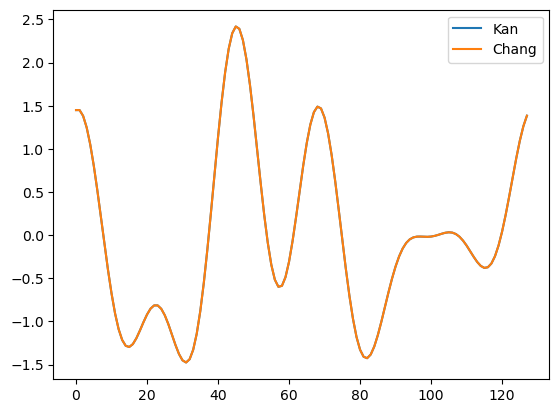

In [50]:
prec_fft2 = np.fft.fft2(prec[:, 32, :])

prec_fft2_filtered = np.zeros(prec_fft2.shape, dtype=np.complex128)
prec_fft2_filtered[:, -6:] = prec_fft2[:, -6:]

prec_ifft = np.fft.ifft2(prec_fft2_filtered).real
print(prec_ifft.shape)

plt.plot((prec_ifft[day_random, :] - prec_ifft[day_random, :].mean())/np.std(prec_ifft[day_random, :]), label="Kan")
plt.plot((prec_anamol_ifft[day_random,32,:] - prec_anamol_ifft[day_random,32,:].mean())/np.std(prec_anamol_ifft[day_random,32,:]), label='Chang')
plt.legend()